# Predicción de Vacunación con CatBoost y Optuna

## Introducción

En este notebook, implementaremos un modelo basado en CatBoost para predecir la probabilidad de vacunación contra H1N1 y vacunas estacionales. Usaremos Optuna para la optimización de hiperparámetros y realizaremos un análisis detallado de las métricas del modelo.

In [2]:
import optuna
import pandas as pd
import numpy as np
import catboost
import sys
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna.visualization as vis
import matplotlib.pyplot as plt

c:\USERS\PABLO\ONEDRIVE\DOCUMENTOS\ESTUDIOS\DATCOM\1ER CUATRIMESTRE\MINERÍA DE DATOS. PREPROCESAMIENTO Y CLASIFICACIÓN\FLUSHOTLEARNING\VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Carga de datos

Comenzamos cargando el dataset preprocesado (preprocessed_training_simple_dataset.csv) que contiene las características, y el archivo de etiquetas (training_set_labels.csv) que incluye las variables objetivo: h1n1_vaccine y seasonal_vaccine.

In [3]:
# Cargar datos
X = pd.read_csv("../../Data/preprocessed_training_simple_dataset.csv", index_col="respondent_id")
y = pd.read_csv("../../Data/training_set_labels.csv", index_col="respondent_id")

## 2. Dividir los datos en conjuntos de entrenamiento y prueba

Separaremos el dataset en entrenamiento (80%) y prueba (20%) para evaluar el rendimiento del modelo.

In [4]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separar las etiquetas para entrenar dos modelos independientes
y_train_h1n1 = y_train['h1n1_vaccine']
y_train_seasonal = y_train['seasonal_vaccine']
y_test_h1n1 = y_test['h1n1_vaccine']
y_test_seasonal = y_test['seasonal_vaccine']

## 3. Optimización de Hiperparámetros con Optuna

Usamos Optuna para encontrar los mejores hiperparámetros para nuestro modelo CatBoost.

### Función Objetivo

La función objetivo define el espacio de búsqueda de hiperparámetros y entrena el modelo en validación cruzada.

In [5]:
train_dataset = Pool(data=X_train,
                     label=y_train['h1n1_vaccine'])

In [6]:
def objective_h1n1(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100, log=True),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [26]:
def objective_seasonal(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100, log=True),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [7]:
# Silenciar Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optimización para H1N1
sampler = optuna.samplers.TPESampler(n_startup_trials=10, seed=42)
study_h1n1 = optuna.create_study(direction='maximize', sampler=sampler)

# Configurar para silenciar toda salida
with open('nul', 'w') as fnull:
    sys.stdout = fnull  # Redirigir toda la salida

    # Ejecutar la optimización con salida silenciada
    study_h1n1.optimize(objective_h1n1, n_trials=50, show_progress_bar=True)

# Restaurar salida estándar
sys.stdout = sys.__stdout__

Best trial: 25. Best value: 0.869567: 100%|██████████| 50/50 [17:56<00:00, 21.54s/it]


In [8]:
optuna.importance.get_param_importances(study_h1n1)

{'max_bin': 0.35270877311227444,
 'learning_rate': 0.30146344315655826,
 'min_data_in_leaf': 0.09768121676603778,
 'l2_leaf_reg': 0.06999175869251471,
 'max_depth': 0.060987552903849294,
 'iterations': 0.047210154653009075,
 'bagging_temperature': 0.02683031160035377,
 'one_hot_max_size': 0.021770996678597943,
 'random_strength': 0.009486698878524,
 'auto_class_weights': 0.006269620575287422,
 'grow_policy': 0.005599472982993472}

In [9]:
vis.plot_param_importances(study_h1n1)

In [14]:
# Mejores hiperparámetros para h1n1_vaccine
best_params_h1n1 = study_h1n1.best_params
print("Mejores hiperparámetros para h1n1_vaccine:", best_params_h1n1)

In [12]:
# Entrenar el modelo H1N1 con los mejores hiperparámetros
model_h1n1 = CatBoostClassifier(**best_params_h1n1, verbose=0)
model_h1n1.fit(X_train, y_train_h1n1)

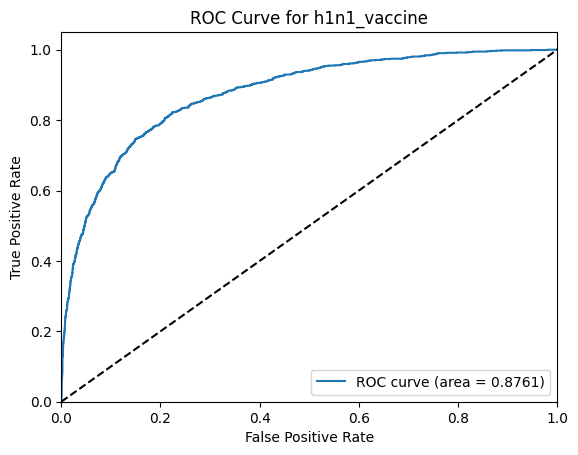

In [13]:
# Predicción y evaluación para H1N1
h1n1_predictions = model_h1n1.predict(X_test)
h1n1_probabilities = model_h1n1.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el valor ROC AUC para h1n1_vaccine
fpr, tpr, thresholds = roc_curve(y_test['h1n1_vaccine'], h1n1_probabilities)
roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], h1n1_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_h1n1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for h1n1_vaccine')
plt.legend(loc="lower right")
plt.show()
print(f"AUROC para H1N1: {roc_auc_h1n1}")

In [ ]:
# Silenciar Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optimización para H1N1
study_seasonal = optuna.create_study(direction='maximize', sampler=sampler)

# Configurar para silenciar toda salida
with open('nul', 'w') as fnull:
    sys.stdout = fnull  # Redirigir toda la salida

    # Ejecutar la optimización con salida silenciada
    study_seasonal.optimize(objective_seasonal, n_trials=50, show_progress_bar=True)

# Restaurar salida estándar
sys.stdout = sys.__stdout__

In [ ]:
optuna.importance.get_param_importances(study_seasonal)

In [ ]:
vis.plot_param_importances(study_seasonal)

In [ ]:
# Mejores hiperparámetros para seasonal_vaccine
best_params_seasonal = study_seasonal.best_params
print("Mejores hiperparámetros para seasonal_vaccine:", best_params_seasonal)

In [ ]:
# Entrenar el modelo Vacuna Estacional con los mejores hiperparámetros
model_seasonal = CatBoostClassifier(**best_params_seasonal, verbose=0)
model_seasonal.fit(X_train, y_train_seasonal)

In [ ]:
# Predicción y evaluación para H1N1
seasonal_predictions = model_seasonal.predict(X_test)
seasonal_probabilities = model_seasonal.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el valor ROC AUC para seasonal_vaccine
fpr, tpr, thresholds = roc_curve(y_test['seasonal_vaccine'], seasonal_probabilities)
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], seasonal_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_seasonal)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for seasonal_vaccine')
plt.legend(loc="lower right")
plt.show()
print(f"AUROC para Seasonal: {roc_auc_seasonal}")

In [ ]:
# Cargar el dataset de prueba preprocesado
test_set_preprocessed = pd.read_csv("../../Data/preprocessed_test_dataset.csv")

# Asegurarse de que respondent_id esté disponible
respondent_ids = test_set_preprocessed['respondent_id']

# Eliminar respondent_id del conjunto de características
X_test_final = test_set_preprocessed.drop(columns=['respondent_id'])

# Predicciones de probabilidad para H1N1
y_proba_h1n1_test = model_h1n1.predict_proba(X_test_final)[:, 1]  # Probabilidades de la clase positiva (1)

# Predicciones de probabilidad para vacuna estacional
y_proba_seasonal_test = model_seasonal.predict_proba(X_test_final)[:, 1]  # Probabilidades de la clase positiva (1)

# Crear el DataFrame de submission
submission = pd.DataFrame({
    "respondent_id": respondent_ids,
    "h1n1_vaccine": y_proba_h1n1_test,
    "seasonal_vaccine": y_proba_seasonal_test
})

# Guardar el archivo de submission
submission.to_csv("Submissions/CatBoost_Optuna_submission.csv", index=False)
print("Archivo 'CatBoost_Optuna_submission.csv' generado correctamente.")